In [13]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
# Import stats from scipy library
from scipy import stats
import statsmodels.api as sm


from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import xgboost as xgb

In [14]:
flights_fe = pd.read_csv(r"../data/2_featue_engineered/2_percent.csv")

In [15]:
flights_fe.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,Rank_des,arr_day_of_week,arr_hour,dep_month,dep_day_of_week,dep_hour,arr_type,arr_severity,dep_type,dep_severity
0,2019-01-02,DL,DL_CODESHARE,DL,5303,9E,N606LR,5303,10397,ATL,...,143.0,2,17,1,2,15,Rain,Light,Rain,Light
1,2019-03-26,DL,DL_CODESHARE,DL,5454,9E,N914XJ,5454,10397,ATL,...,143.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,2019-04-17,DL,DL_CODESHARE,DL,5443,9E,N901XJ,5443,10397,ATL,...,143.0,2,17,4,2,15,Rain,Light,Rain,Light
3,2019-05-12,DL,DL_CODESHARE,DL,5371,9E,N197PQ,5371,10397,ATL,...,143.0,6,12,5,6,10,Rain,Light,Rain,Light
4,2019-06-09,DL,DL_CODESHARE,DL,5197,9E,N916XJ,5197,10397,ATL,...,143.0,6,17,6,6,15,Fog,Moderate,Rain,Light


In [16]:
flights_fe.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name', 'arr_date_time', 'dep_date_time',
       'arr_month', 'origin_airport_type', 'dest_airport_type',
       'inbound_flights', 'dep_flights_count', 'arr_flights_count',
       'origin_state', 'dest_state', 'origin_population', 'dest_population',
       'Locid', 'C

## Target variable

<AxesSubplot:ylabel='arr_delay'>

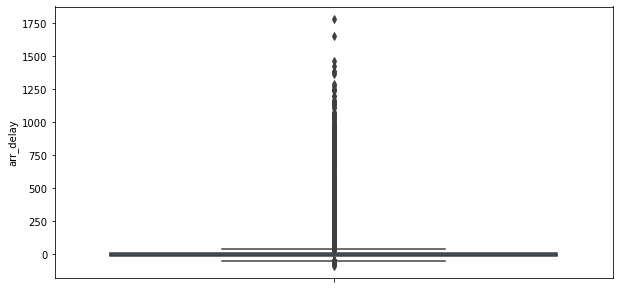

In [17]:
plt.rcParams["figure.figsize"] = (10,5)
sns.boxplot(y=flights_fe.arr_delay)

In [18]:
100*flights_fe.arr_delay.isna().sum()/flights_fe.shape[0]

2.0943555292977436

In [19]:
# drop outliers
flights_fe = flights_fe[~flights_fe.arr_delay.isna()]
flights_fe.arr_delay.isna().sum()/flights_fe.shape[0]

0.0

In [20]:
# Interquartile range (IQR)
IQR = stats.iqr(flights_fe.arr_delay, interpolation = 'midpoint')

# First quartile (Q1)
Q1 = np.percentile(flights_fe.arr_delay, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(flights_fe.arr_delay, 75, interpolation = 'midpoint')
  
print(IQR)

22.0


In [21]:
flights_fe = flights_fe[(flights_fe.arr_delay<(Q3 + 1.5*IQR)) & (flights_fe.arr_delay>(Q1 - 1.5*IQR))]

D:\Anaconda\envs\geo_env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


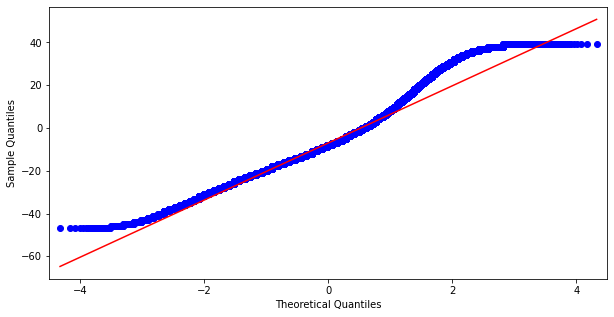

In [22]:
sm.qqplot(data=flights_fe.arr_delay,line='q')
plt.show()

<AxesSubplot:ylabel='arr_delay'>

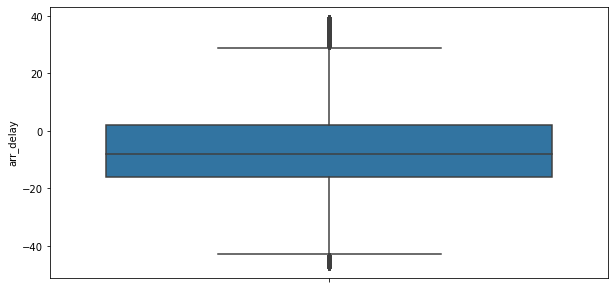

In [23]:
sns.boxplot(y=flights_fe.arr_delay)

In [24]:
flights_fe.shape

(132665, 89)

## Missing values

In [25]:
(flights_fe.isna().sum()).sort_values(ascending=False).head(15)

no_name                132665
cancellation_code      132665
total_add_gtime        132463
first_dep_time         132463
longest_add_gtime      132463
carrier_delay          119116
weather_delay          119116
nas_delay              119116
security_delay         119116
late_aircraft_delay    119116
dep_severity             3936
dep_type                 3936
arr_severity             3859
arr_type                 3859
area_or                   163
dtype: int64

In [26]:
drop_columns = (flights_fe.isna().sum()).sort_values(ascending=False).head(10).index.values

In [27]:
flights_fe = flights_fe.drop(columns=drop_columns)

In [28]:
(flights_fe.isna().sum()).sort_values(ascending=False).head(10)

dep_severity          3936
dep_type              3936
arr_severity          3859
arr_type              3859
area_or                163
area_des               159
hub_type_or             42
hub_type_des            28
Locid                   27
CY 19 Enplanements      27
dtype: int64

<AxesSubplot:xlabel='dep_severity', ylabel='count'>

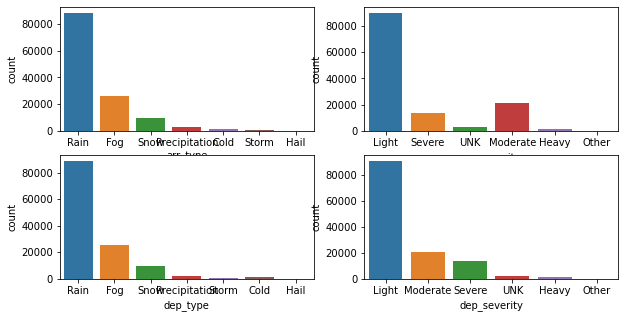

In [29]:
fig,axs = plt.subplots(2,2)
sns.countplot(x=flights_fe.arr_type,ax=axs[0][0])
sns.countplot(x=flights_fe.arr_severity,ax=axs[0][1])
sns.countplot(x=flights_fe.dep_type,ax=axs[1][0])
sns.countplot(x=flights_fe.dep_severity,ax=axs[1][1])

In [30]:
flights_fe.arr_type = flights_fe.arr_type.fillna(flights_fe.arr_type.describe().top)
flights_fe.arr_severity = flights_fe.arr_severity.fillna(flights_fe.arr_severity.describe().top)
flights_fe.dep_type = flights_fe.dep_type.fillna(flights_fe.dep_type.describe().top)
flights_fe.dep_severity = flights_fe.dep_severity.fillna(flights_fe.dep_severity.describe().top)

In [40]:
flights_fe.area_des = flights_fe.area_des.fillna(flights_fe.area_des.mean())
flights_fe.area_or = flights_fe.area_or.fillna(flights_fe.area_or.mean())
flights_fe["CY 19 Enplanements"] = flights_fe["CY 19 Enplanements"].fillna(flights_fe["CY 19 Enplanements"].mean())

In [41]:
flights_fe.hub_type_des.describe().top

'Large'

In [42]:
flights_fe.hub_type_or.describe().top

'Large'

In [43]:
flights_fe.hub_type_des = flights_fe.hub_type_des.fillna(flights_fe.hub_type_des.describe().top)
flights_fe.hub_type_or = flights_fe.hub_type_or.fillna(flights_fe.hub_type_or.describe().top)

In [49]:
try:
    flights_fe = flights_fe.drop(columns=["Locid"])
    flights_fe = flights_fe.drop(columns=["Rank_or"])
    flights_fe = flights_fe.drop(columns=["beacon_color_or"])
    flights_fe = flights_fe.drop(columns=["beacon_color_des"])
    flights_fe = flights_fe.drop(columns=["Rank_des"])
except:
    print("Already dropped")

In [50]:
(flights_fe.isna().sum()).sort_values(ascending=False).head(10)

fl_date                       0
service_level_des             0
avg_runway_length_or          0
num_runways_or                0
total_operations_annual_or    0
fss_on_airport_or             0
area_or                       0
facility_use_or               0
ownership_status_or           0
hub_type_or                   0
dtype: int64

In [51]:
flights_fe.shape

(132665, 74)

## Preprocessing

In [53]:
flights_dropped = flights_fe.copy()

In [54]:
flights_fe.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted', 'dup',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'arr_date_time', 'dep_date_time', 'arr_month',
       'origin_airport_type', 'dest_airport_type', 'inbound_flights',
       'dep_flights_count', 'arr_flights_count', 'origin_state', 'dest_state',
       'origin_population', 'dest_population', 'CY 19 Enplanements',
       'service_level_or', 'hub_type_or', 'ownership_status_or',
       'facility_use_or', 'area_or', 'fss_on_airport_or',
       'total_operations_annual_or', 'num_runways_or', 'avg_runway_lengt

In [55]:
test_columns = ["mkt_unique_carrier","branded_code_share",
               "mkt_carrier","mkt_carrier_fl_num",
               "op_unique_carrier","tail_num","op_carrier_fl_num",
               "origin_airport_id","origin","origin_city_name",
               "dest_airport_id","dest","dest_city_name","crs_elapsed_time",
               "flights","distance","arr_delay"]

weather_features = ['arr_type','arr_severity', 'dep_type', 'dep_severity']

population_features = ['origin_population','dest_population']

timing_features = ['arr_date_time', 'dep_date_time', 'arr_month','arr_day_of_week', 'arr_hour','dep_month', 'dep_day_of_week', 'dep_hour']

or_airport_features = ['service_level_or','hub_type_or', 'ownership_status_or', 'facility_use_or', 'area_or',
                    'fss_on_airport_or', 'total_operations_annual_or','num_runways_or', 
                    'avg_runway_length_or', 'avg_runway_width_or','CY 19 Enplanements']

dest_airport_features = ['service_level_des', 'hub_type_des', 'ownership_status_des','facility_use_des', 'area_des', 
                         'fss_on_airport_des', 'total_operations_annual_des', 'num_runways_des',
                         'avg_runway_length_des', 'avg_runway_width_des']

from_data = ['origin_airport_type','dest_airport_type', 'inbound_flights', 
             'dep_flights_count','arr_flights_count', 'origin_state', 'dest_state']

features_to_keep = test_columns+weather_features+population_features+timing_features+or_airport_features+dest_airport_features+from_data

columns_to_drop = set(flights_dropped.columns).difference(set(features_to_keep))
flights_dropped = flights_dropped.drop(columns=columns_to_drop)

In [56]:
repetitive_columns = ["branded_code_share","mkt_carrier","tail_num","mkt_carrier_fl_num",
                      "origin_airport_id","dest_airport_id","flights"]
flights_dropped = flights_dropped.drop(columns=repetitive_columns)

In [57]:
flights_dropped  = flights_dropped.drop(columns=["arr_date_time","dep_date_time"])
flights_dropped.head()

,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,dest,dest_city_name,arr_delay,crs_elapsed_time,distance,...,avg_runway_width_des,arr_day_of_week,arr_hour,dep_month,dep_day_of_week,dep_hour,arr_type,arr_severity,dep_type,dep_severity
0,DL,9E,5303,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-17.0,121.0,692.0,...,150.0,2,17,1,2,15,Rain,Light,Rain,Light
1,DL,9E,5454,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-12.0,123.0,692.0,...,150.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,DL,9E,5443,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-23.0,129.0,692.0,...,150.0,2,17,4,2,15,Rain,Light,Rain,Light
3,DL,9E,5371,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",5.0,123.0,692.0,...,150.0,6,12,5,6,10,Rain,Light,Rain,Light
6,DL,9E,5197,ATL,"Atlanta, GA",ABE,"Allentown/Bethlehem/Easton, PA",-29.0,132.0,692.0,...,150.0,0,17,8,0,15,Rain,Light,Rain,Light


In [58]:
flights_dropped = flights_dropped.drop(columns=["dest_city_name","dest","origin","origin_city_name"])
flights_dropped.head()

,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,arr_delay,crs_elapsed_time,distance,arr_month,origin_airport_type,dest_airport_type,inbound_flights,...,avg_runway_width_des,arr_day_of_week,arr_hour,dep_month,dep_day_of_week,dep_hour,arr_type,arr_severity,dep_type,dep_severity
0,DL,9E,5303,-17.0,121.0,692.0,1,Very Large,Large,2,...,150.0,2,17,1,2,15,Rain,Light,Rain,Light
1,DL,9E,5454,-12.0,123.0,692.0,3,Very Large,Large,0,...,150.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,DL,9E,5443,-23.0,129.0,692.0,4,Very Large,Large,1,...,150.0,2,17,4,2,15,Rain,Light,Rain,Light
3,DL,9E,5371,5.0,123.0,692.0,5,Very Large,Large,1,...,150.0,6,12,5,6,10,Rain,Light,Rain,Light
6,DL,9E,5197,-29.0,132.0,692.0,8,Very Large,Large,1,...,150.0,0,17,8,0,15,Rain,Light,Rain,Light


In [59]:
flights_dropped.columns

Index(['mkt_unique_carrier', 'op_unique_carrier', 'op_carrier_fl_num',
       'arr_delay', 'crs_elapsed_time', 'distance', 'arr_month',
       'origin_airport_type', 'dest_airport_type', 'inbound_flights',
       'dep_flights_count', 'arr_flights_count', 'origin_state', 'dest_state',
       'origin_population', 'dest_population', 'CY 19 Enplanements',
       'service_level_or', 'hub_type_or', 'ownership_status_or',
       'facility_use_or', 'area_or', 'fss_on_airport_or',
       'total_operations_annual_or', 'num_runways_or', 'avg_runway_length_or',
       'avg_runway_width_or', 'service_level_des', 'hub_type_des',
       'ownership_status_des', 'facility_use_des', 'area_des',
       'fss_on_airport_des', 'total_operations_annual_des', 'num_runways_des',
       'avg_runway_length_des', 'avg_runway_width_des', 'arr_day_of_week',
       'arr_hour', 'dep_month', 'dep_day_of_week', 'dep_hour', 'arr_type',
       'arr_severity', 'dep_type', 'dep_severity'],
      dtype='object')

(array([   37.,  1118.,  4550., 12215., 22082., 32395., 33444., 17593.,
         9007.,   224.]),
 array([3.4339872 , 3.94418998, 4.45439275, 4.96459553, 5.4747983 ,
        5.98500108, 6.49520385, 7.00540662, 7.5156094 , 8.02581217,
        8.53601495]),
 <BarContainer object of 10 artists>)

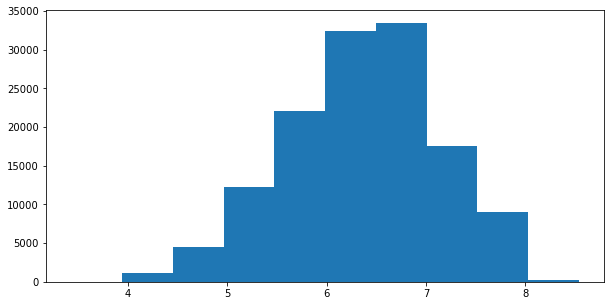

In [60]:
flights_dropped.distance = np.log(flights_dropped.distance)
plt.hist(flights_dropped.distance)

## Modelling

In [61]:
flights_modelling = flights_dropped.copy()

In [62]:
flights_modelling = flights_modelling.convert_dtypes()

In [63]:
X,y = flights_modelling.drop(columns=["arr_delay"]), flights_modelling["arr_delay"]

In [64]:
X.head()

,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,crs_elapsed_time,distance,arr_month,origin_airport_type,dest_airport_type,inbound_flights,dep_flights_count,...,avg_runway_width_des,arr_day_of_week,arr_hour,dep_month,dep_day_of_week,dep_hour,arr_type,arr_severity,dep_type,dep_severity
0,DL,9E,5303,121,6.539586,1,Very Large,Large,2,1,...,150.0,2,17,1,2,15,Rain,Light,Rain,Light
1,DL,9E,5454,123,6.539586,3,Very Large,Large,0,0,...,150.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,DL,9E,5443,129,6.539586,4,Very Large,Large,1,1,...,150.0,2,17,4,2,15,Rain,Light,Rain,Light
3,DL,9E,5371,123,6.539586,5,Very Large,Large,1,1,...,150.0,6,12,5,6,10,Rain,Light,Rain,Light
6,DL,9E,5197,132,6.539586,8,Very Large,Large,1,4,...,150.0,0,17,8,0,15,Rain,Light,Rain,Light


In [65]:
X.shape

(132665, 45)

## Polynomial features

In [67]:
# original version had class ColumnExtractor(object)
# estimators need to inherit from these classes to play nicely with others
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

In [68]:
poly = PolynomialFeatures()

In [69]:
cols_to_poly = ["distance","inbound_flights"]
remaining_columns = [col for col in X.columns if col not in cols_to_poly]

In [70]:
# Using pandas get dummies to make pipeline a bit simpler by
# avoiding one-hot and label encoder.     
# Build the pipeline from a FeatureUnion that processes 
# numerical and one-hot encoded separately.
# FeatureUnion puts them back together when it's done.
pipe2nvars = Pipeline([
    ('features', FeatureUnion([('num', 
                                Pipeline([('extract', 
                                           ColumnExtractor(columns=cols_to_poly)),
                                          ('poly', 
                                           poly)  ])),
                               ('cat_var', 
                                ColumnExtractor(columns=remaining_columns))])
    )])   

In [71]:
pipe2nvars.set_params(features__num__poly__degree=2)
X = pd.DataFrame(pipe2nvars.fit_transform(X))

In [72]:
cols = poly.get_feature_names(input_features=cols_to_poly)+remaining_columns
cols = dict(zip(range(X.shape[1]),cols))
X = X.rename(columns=cols)

In [73]:
X.head()

,1,distance,inbound_flights,distance^2,distance inbound_flights,inbound_flights^2,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,crs_elapsed_time,...,avg_runway_width_des,arr_day_of_week,arr_hour,dep_month,dep_day_of_week,dep_hour,arr_type,arr_severity,dep_type,dep_severity
0,1.0,6.539586,2.0,42.766184,13.079172,4.0,DL,9E,5303,121,...,150.0,2,17,1,2,15,Rain,Light,Rain,Light
1,1.0,6.539586,0.0,42.766184,0.0,0.0,DL,9E,5454,123,...,150.0,1,12,3,1,10,Rain,Light,Rain,Moderate
2,1.0,6.539586,1.0,42.766184,6.539586,1.0,DL,9E,5443,129,...,150.0,2,17,4,2,15,Rain,Light,Rain,Light
3,1.0,6.539586,1.0,42.766184,6.539586,1.0,DL,9E,5371,123,...,150.0,6,12,5,6,10,Rain,Light,Rain,Light
4,1.0,6.539586,1.0,42.766184,6.539586,1.0,DL,9E,5197,132,...,150.0,0,17,8,0,15,Rain,Light,Rain,Light


## One hot encoding

In [126]:
X_dummy = X.drop(columns=["op_carrier_fl_num",
                          'origin_airport_type','dest_airport_type',
                          "num_runways_des","num_runways_or",
                          "avg_runway_length_or","avg_runway_width_or",
                          "avg_runway_length_des","avg_runway_width_des",
                          'ownership_status_des','facility_use_des',
                          'ownership_status_or', 'facility_use_or'
                          ,'arr_severity', 'dep_type', 'dep_severity'
                         ])

In [127]:
X_dummy = pd.get_dummies(
    data=X_dummy,columns=["mkt_unique_carrier","op_unique_carrier"])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['arr_month','arr_day_of_week', 'arr_hour',
                          'dep_month', 'dep_day_of_week', 'dep_hour',])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['service_level_or','hub_type_or', 'fss_on_airport_or'])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['hub_type_des',  'fss_on_airport_des','service_level_des',])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['origin_state', 'dest_state',])

X_dummy = pd.get_dummies(
    data=X_dummy,columns=['arr_type'])      

X_dummy.shape

(132665, 269)

In [128]:
X_dummy.columns

Index(['1', 'distance', 'inbound_flights', 'distance^2',
       'distance inbound_flights', 'inbound_flights^2', 'crs_elapsed_time',
       'dep_flights_count', 'arr_flights_count', 'origin_population',
       ...
       'dest_state_WI', 'dest_state_WV', 'dest_state_WY', 'arr_type_Cold',
       'arr_type_Fog', 'arr_type_Hail', 'arr_type_Precipitation',
       'arr_type_Rain', 'arr_type_Snow', 'arr_type_Storm'],
      dtype='object', length=269)

In [129]:
pd.set_option('display.max_columns', None)
X_dummy.head()

,1,distance,inbound_flights,distance^2,distance inbound_flights,inbound_flights^2,crs_elapsed_time,dep_flights_count,arr_flights_count,origin_population,dest_population,CY 19 Enplanements,area_or,total_operations_annual_or,area_des,total_operations_annual_des,mkt_unique_carrier_AA,mkt_unique_carrier_AS,mkt_unique_carrier_B6,mkt_unique_carrier_DL,mkt_unique_carrier_F9,mkt_unique_carrier_G4,mkt_unique_carrier_HA,mkt_unique_carrier_NK,mkt_unique_carrier_UA,mkt_unique_carrier_WN,op_unique_carrier_9E,op_unique_carrier_AA,op_unique_carrier_AS,op_unique_carrier_AX,op_unique_carrier_B6,op_unique_carrier_C5,op_unique_carrier_CP,op_unique_carrier_DL,op_unique_carrier_EM,op_unique_carrier_EV,op_unique_carrier_F9,op_unique_carrier_G4,op_unique_carrier_G7,op_unique_carrier_HA,op_unique_carrier_KS,op_unique_carrier_MQ,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW,arr_month_1,arr_month_2,arr_month_3,arr_month_4,arr_month_5,arr_month_6,arr_month_7,arr_month_8,arr_month_9,arr_month_10,arr_month_11,arr_month_12,arr_day_of_week_0,arr_day_of_week_1,arr_day_of_week_2,arr_day_of_week_3,arr_day_of_week_4,arr_day_of_week_5,arr_day_of_week_6,arr_hour_0,arr_hour_1,arr_hour_2,arr_hour_3,arr_hour_4,arr_hour_5,arr_hour_6,arr_hour_7,arr_hour_8,arr_hour_9,arr_hour_10,arr_hour_11,arr_hour_12,arr_hour_13,arr_hour_14,arr_hour_15,arr_hour_16,arr_hour_17,arr_hour_18,arr_hour_19,arr_hour_20,arr_hour_21,arr_hour_22,arr_hour_23,dep_month_1,dep_month_2,dep_month_3,dep_month_4,dep_month_5,dep_month_6,dep_month_7,dep_month_8,dep_month_9,dep_month_10,dep_month_11,dep_month_12,dep_day_of_week_0,dep_day_of_week_1,dep_day_of_week_2,dep_day_of_week_3,dep_day_of_week_4,dep_day_of_week_5,dep_day_of_week_6,dep_hour_0,dep_hour_1,dep_hour_2,dep_hour_3,dep_hour_4,dep_hour_5,dep_hour_6,dep_hour_7,dep_hour_8,dep_hour_9,dep_hour_10,dep_hour_11,dep_hour_12,dep_hour_13,dep_hour_14,dep_hour_15,dep_hour_16,dep_hour_17,dep_hour_18,dep_hour_19,dep_hour_20,dep_hour_21,dep_hour_22,dep_hour_23,service_level_or_Commercial Service,service_level_or_General Aviation,service_level_or_Primary,hub_type_or_Large,hub_type_or_Medium,hub_type_or_Non-Hub,hub_type_or_Small,fss_on_airport_or_NO,fss_on_airport_or_YES,hub_type_des_Large,hub_type_des_Medium,hub_type_des_Non-Hub,hub_type_des_Small,fss_on_airport_des_NO,fss_on_airport_des_YES,service_level_des_Commercial Service,service_level_des_General Aviation,service_level_des_Primary,origin_state_AK,origin_state_AL,origin_state_AR,origin_state_AZ,origin_state_CA,origin_state_CO,origin_state_CT,origin_state_DC,origin_state_FL,origin_state_GA,origin_state_HI,origin_state_IA,origin_state_ID,origin_state_IL,origin_state_IN,origin_state_KS,origin_state_KY,origin_state_LA,origin_state_MA,origin_state_MD,origin_state_ME,origin_state_MI,origin_state_MN,origin_state_MO,origin_state_MS,origin_state_MT,origin_state_NC,origin_state_ND,origin_state_NE,origin_state_NH,origin_state_NJ,origin_state_NM,origin_state_NV,origin_state_NY,origin_state_OH,origin_state_OK,origin_state_OR,origin_state_PA,origin_state_PR,origin_state_RI,origin_state_SC,origin_state_SD,origin_state_TN,origin_state_TT,origin_state_TX,origin_state_UT,origin_state_VA,origin_state_VI,origin_state_VT,origin_state_WA,origin_state_WI,origin_state_WV,origin_state_WY,dest_state_AK,dest_state_AL,dest_state_AR,dest_state_AZ,dest_state_CA,dest_state_CO,dest_state_CT,dest_state_DC,dest_state_FL,dest_state_GA,dest_state_HI,dest_state_IA,dest_state_ID,dest_state_IL,dest_state_IN,dest_state_KS,dest_state_KY,dest_state_LA,dest_state_MA,dest_state_MD,dest_state_ME,dest_state_MI,dest_state_MN,dest_state_MO,dest_state_MS,dest_state_MT,dest_state_NC,dest_state_ND,dest_state_NE,dest_state_NH,dest_state_NJ,dest_state_NM,dest_state_NV,dest_state_NY,dest_state_OH,dest_state_OK,dest_state_OR,dest_state_PA,dest_state_PR,dest_state_RI,dest_state_SC,dest_state_SD,d

### Scaling features

In [130]:
# scaler= StandardScaler()
scaler = MinMaxScaler()

In [131]:
X_scaled = pd.DataFrame(scaler.fit_transform(X=X_dummy),columns=X_dummy.columns)

In [132]:
X_scaled.shape

(132665, 269)

## Feature Importance

In [133]:

#transformation
#scale features

# polynomial regression
# p-value for coefficients

#

In [141]:
# X_s = X_scaled
X_s = X_dummy

In [142]:
X_train,X_test,y_train,y_test = train_test_split(X_s,y,train_size=0.7,random_state=1234)

In [143]:
X_train.shape

(92865, 269)

In [144]:
reg = LinearRegression()
# sfs = SequentialFeatureSelector(reg)
# sfs.fit(X_train, y_train)

In [145]:

model = GridSearchCV(reg,param_grid={})
model.fit(X_train,y_train)

D:\Anaconda\envs\geo_env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly

GridSearchCV(estimator=LinearRegression(), param_grid={})

In [146]:
y_pred = model.predict(X_test)

In [147]:
print(r2_score(y_test,y_pred))

0.03830163871719172


D:\Anaconda\envs\geo_env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [1248]:
params = {'criterion' : ['mse'],'n_estimators':[100]}

In [1249]:
reg = RandomForestRegressor()
model = GridSearchCV(reg,param_grid=params)
model.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse'], 'n_estimators': [100]})

In [1250]:
y_pred = model.predict(X_test)
print(r2_score(y_test,y_pred))

0.0013254389083622309


In [1262]:
#  [ {'booster':'gbtree',"verbosity":[2],'eta':uniform(0.01,0.3),"max_depth":uniform(1,6),"n_estimators":[1000]},
params =  [{'booster':['gbtree'],"verbosity":[1],'eta':[0.001,0.01,0.3],"max_depth":[4,5,6],"n_estimators":[1000,1500]}]

In [ ]:

xgb_r = xgb.XGBRegressor(objective='reg:squarederror')

random_search = GridSearchCV(xgb_r, param_grid=params,scoring='r2', verbose=3)


random_search.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END booster=gbtree, eta=0.001, max_depth=4, n_estimators=1000, verbosity=1;, score=-0.006 total time= 1.5min
[CV 2/5] END booster=gbtree, eta=0.001, max_depth=4, n_estimators=1000, verbosity=1;, score=-0.015 total time= 1.7min
[CV 3/5] END booster=gbtree, eta=0.001, max_depth=4, n_estimators=1000, verbosity=1;, score=-0.008 total time= 1.8min
[CV 4/5] END booster=gbtree, eta=0.001, max_depth=4, n_estimators=1000, verbosity=1;, score=-0.011 total time= 1.8min
[CV 5/5] END booster=gbtree, eta=0.001, max_depth=4, n_estimators=1000, verbosity=1;, score=-0.009 total time= 1.8min
[CV 1/5] END booster=gbtree, eta=0.001, max_depth=4, n_estimators=1500, verbosity=1;, score=0.012 total time= 2.9min
[CV 2/5] END booster=gbtree, eta=0.001, max_depth=4, n_estimators=1500, verbosity=1;, score=0.008 total time= 2.9min
[CV 3/5] END booster=gbtree, eta=0.001, max_depth=4, n_estimators=1500, verbosity=1;, score=0.012 total time= 3.1mi

In [ ]:
# Predict the model
pred = random_search.predict(X_test)

r2_score(y_test, pred)

In [1261]:
random_search.best_params_

{'booster': 'gbtree',
 'eta': 0.01,
 'max_depth': 6,
 'n_estimators': 1000,
 'verbosity': 2}

### selecting features by p-value

In [1218]:
gamma_model = sm.GLM(y_train.values,X_train.values)

In [1219]:
gamma_results = gamma_model.fit()

In [1256]:
cols_with_high_p_value = (pd.DataFrame(gamma_results.pvalues,index=X_dummy.columns))

In [1257]:
cols_with_high_p_value

,0
1,0.344897
distance,0.004339
inbound_flights,0.370107
num_runways_des,0.012071
num_runways_or,0.192074
...,...
dep_severity_Light,0.000152
dep_severity_Moderate,0.490857
dep_severity_Other,0.415166
dep_severity_Severe,0.117980


In [1258]:
cols_with_high_p_value['Params']=gamma_results.params

In [1260]:
cols_with_high_p_value.sort_values(by=['Params'],ascending=False)

,0,Params
origin_state_TT,9.987887e-03,16.649660
dest_state_TT,4.762740e-01,5.957161
mkt_unique_carrier_HA,1.926377e-14,5.822830
dep_hour_4,1.256461e-01,5.195439
op_unique_carrier_EM,6.541177e-05,5.067846
...,...,...
origin_state_NH,1.120762e-02,-3.372640
Rank_des,3.105322e-03,-3.973836
num_runways_des,1.207114e-02,-4.117402
origin_state_VI,2.189971e-02,-4.205782


In [1242]:
# from sklearn.feature_selection import SelectKBest,f_regression

In [1243]:
# selector = SelectKBest(f_regression, k=200)
# X_new = selector.fit_transform(X_dummy, y)

In [1244]:
# pd.DataFrame({'columns':X_dummy.columns,'scores':selector.scores_}).sort_values(by=["scores"],ascending=False).head(20)